In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, learning_curve, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

In [2]:
#3.2 EXPLORE DATA
#Import database
df = pd.read_csv('C:/Users/502694/OneDrive - BRF S.A/Desktop/Base final.csv',sep=";")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CAAF                     6716 non-null   object 
 1   Sexo                     6716 non-null   object 
 2   Linhagem                 6716 non-null   int64  
 3   Categoria                6716 non-null   object 
 4   Tipo Ventilação          5956 non-null   object 
 5   Dist. Abatedouro         6716 non-null   int64  
 6   Área Util                6716 non-null   int64  
 7   Nº Cama                  6716 non-null   int64  
 8   Origem Incubatório       6716 non-null   object 
 9   ID Matriz                6716 non-null   object 
 10  Data Hora Aloj           6716 non-null   object 
 11  Data Abate               6716 non-null   object 
 12  ID Abate                 6716 non-null   object 
 13  Densidade Abate (Kg/M²)  6716 non-null   object 
 14  PM                      

In [3]:
# Check information in columns
pd.set_option('display.max_columns', None)
print(df.head())

     CAAF   Sexo  Linhagem Categoria Tipo Ventilação  Dist. Abatedouro  \
0  1,2773  Fêmea        75    FGO LV      Dark modal                37   
1  1,2901  Fêmea        75    FGO LV      Dark modal               156   
2   1,297  Fêmea        75    FGO LV      Dark modal               156   
3  1,3094  Fêmea        75    FGO LV        Positiva                28   
4  1,3187  Fêmea        75    FGO LV        Positiva                26   

   Área Util  Nº Cama          Origem Incubatório ID Matriz    Data Hora Aloj  \
0       2400        1      INCUB. AVES SANTA GEMA     38,73  20/10/2023 15:45   
1       2400        1  INCUB. AVES HERVAL D OESTE      34,9  28/04/2023 13:35   
2       2400        1      INCUB. AVES SANTA GEMA     44,94  28/04/2023 13:46   
3       1200        1      INCUB. AVES SANTA GEMA        46  06/10/2023 14:25   
4       1200        3      INCUB. AVES SANTA GEMA        55  23/08/2023 13:00   

         Data Abate ID Abate Densidade Abate (Kg/M²)     PM     CA %

In [4]:
#Replace , for . in columns
columns_to_replace = ['CAAF', 'CA', 'ID Matriz', 'Peso Alojamento', 'Pre-Inicial(kg/ave)', 'Inicial(Kg/ave)','Crescimento - I(Kg/ave)','Final-II(Kg/ave)','% MT','% Mort 07','% Mort 14',
                      '% Mort 21','Densidade Alojamento','Densidade Abate (Kg/M²)','Real_Calo_Pata_A','ID Abate','% Condenação Total','% Condenação Parcial','PM']
df[columns_to_replace] = df[columns_to_replace].replace(',', '.', regex=True)

# Convert columns to numeric format
numeric_columns = ['CAAF', 'CA', 'ID Matriz', 'Peso Alojamento', 'Pre-Inicial(kg/ave)', 'Inicial(Kg/ave)','Crescimento - I(Kg/ave)','Final-II(Kg/ave)','% MT','% Mort 07','% Mort 14',
                   '% Mort 21','Densidade Alojamento','Densidade Abate (Kg/M²)','Real_Calo_Pata_A','ID Abate','% Condenação Total','% Condenação Parcial','PM','Intervalo Diário','Dist. Abatedouro',
                   'Área Util',]                    
df[numeric_columns] = df[numeric_columns].astype(float)

# Convert columns to integer format
df['Nº Cama'] = df['Nº Cama'].astype(int)

# Convert columns to category format
df['Extensionista'] = df['Extensionista'].astype(str).str.replace('\.0', '', regex=True)
category_columns = ['Nº Lote','Linhagem','Timer Iluminação','Origem Incubatório','Sexo','Categoria','Tipo Ventilação','Tipo Telhado','Município','Origem Água','Extensionista','Nº Fornecedor']
df[category_columns] = df[category_columns].astype('category')

#Convert to datetime
df['Data Hora Aloj'] = pd.to_datetime(df['Data Hora Aloj'], dayfirst=True)
df['Data Abate'] = pd.to_datetime(df['Data Abate'], dayfirst=True)

#print(df.head(30))
#print(df.info())
#print(df.groupby('Município')['Nº Lote'].count())

In [5]:
# Unique values in each column
unique_counts = df.nunique()
print(unique_counts)

CAAF                       3258
Sexo                          3
Linhagem                      4
Categoria                     2
Tipo Ventilação               5
Dist. Abatedouro             99
Área Util                    13
Nº Cama                      65
Origem Incubatório           11
ID Matriz                  2757
Data Hora Aloj             6370
Data Abate                 6694
ID Abate                    203
Densidade Abate (Kg/M²)    1681
PM                          662
CA                          575
% Mort 07                   408
% Mort 14                   304
% Mort 21                   254
% MT                       6229
Peso Alojamento              24
% Condenação Parcial         55
% Condenação Total          223
Real_Calo_Pata_A           6099
Origem Água                  10
Timer Iluminação              3
Tipo Telhado                 10
Extensionista                20
Nº Fornecedor               312
Nº Lote                    6716
Município                    13
Densidad

In [6]:
# Check for missing values in each column
missing_counts = df.isna().sum()
print(missing_counts)

CAAF                          0
Sexo                          0
Linhagem                      0
Categoria                     0
Tipo Ventilação             760
Dist. Abatedouro              0
Área Util                     0
Nº Cama                       0
Origem Incubatório            0
ID Matriz                     0
Data Hora Aloj                0
Data Abate                    0
ID Abate                      0
Densidade Abate (Kg/M²)       0
PM                            0
CA                            0
% Mort 07                     0
% Mort 14                     0
% Mort 21                     0
% MT                          0
Peso Alojamento               0
% Condenação Parcial          0
% Condenação Total            0
Real_Calo_Pata_A              0
Origem Água                1308
Timer Iluminação           1798
Tipo Telhado               1034
Extensionista                 0
Nº Fornecedor                 0
Nº Lote                       0
Município                     0
Densidad

In [7]:
# Check statistics description
print(df.describe().round(3))

           CAAF  Dist. Abatedouro  Área Util   Nº Cama  ID Matriz  \
count  6716.000          6716.000   6716.000  6716.000   6716.000   
mean      1.585            43.644   1938.262    15.914     41.893   
min       1.277             0.000    600.000     1.000    -13.000   
25%       1.510            18.000   1200.000     7.000     32.550   
50%       1.576            34.000   1800.000    14.000     40.110   
75%       1.647            58.000   2400.000    23.000     50.215   
max       4.016           271.000   4800.000    65.000     69.340   
std       0.112            41.215    937.497    11.100     10.734   

                      Data Hora Aloj                     Data Abate  ID Abate  \
count                           6716                           6716  6716.000   
mean   2022-09-19 12:21:30.902322944  2022-10-20 12:07:18.368076544    30.289   
min              2021-07-27 11:40:00            2021-09-01 02:07:00    17.200   
25%              2022-02-18 18:49:30            2022-0

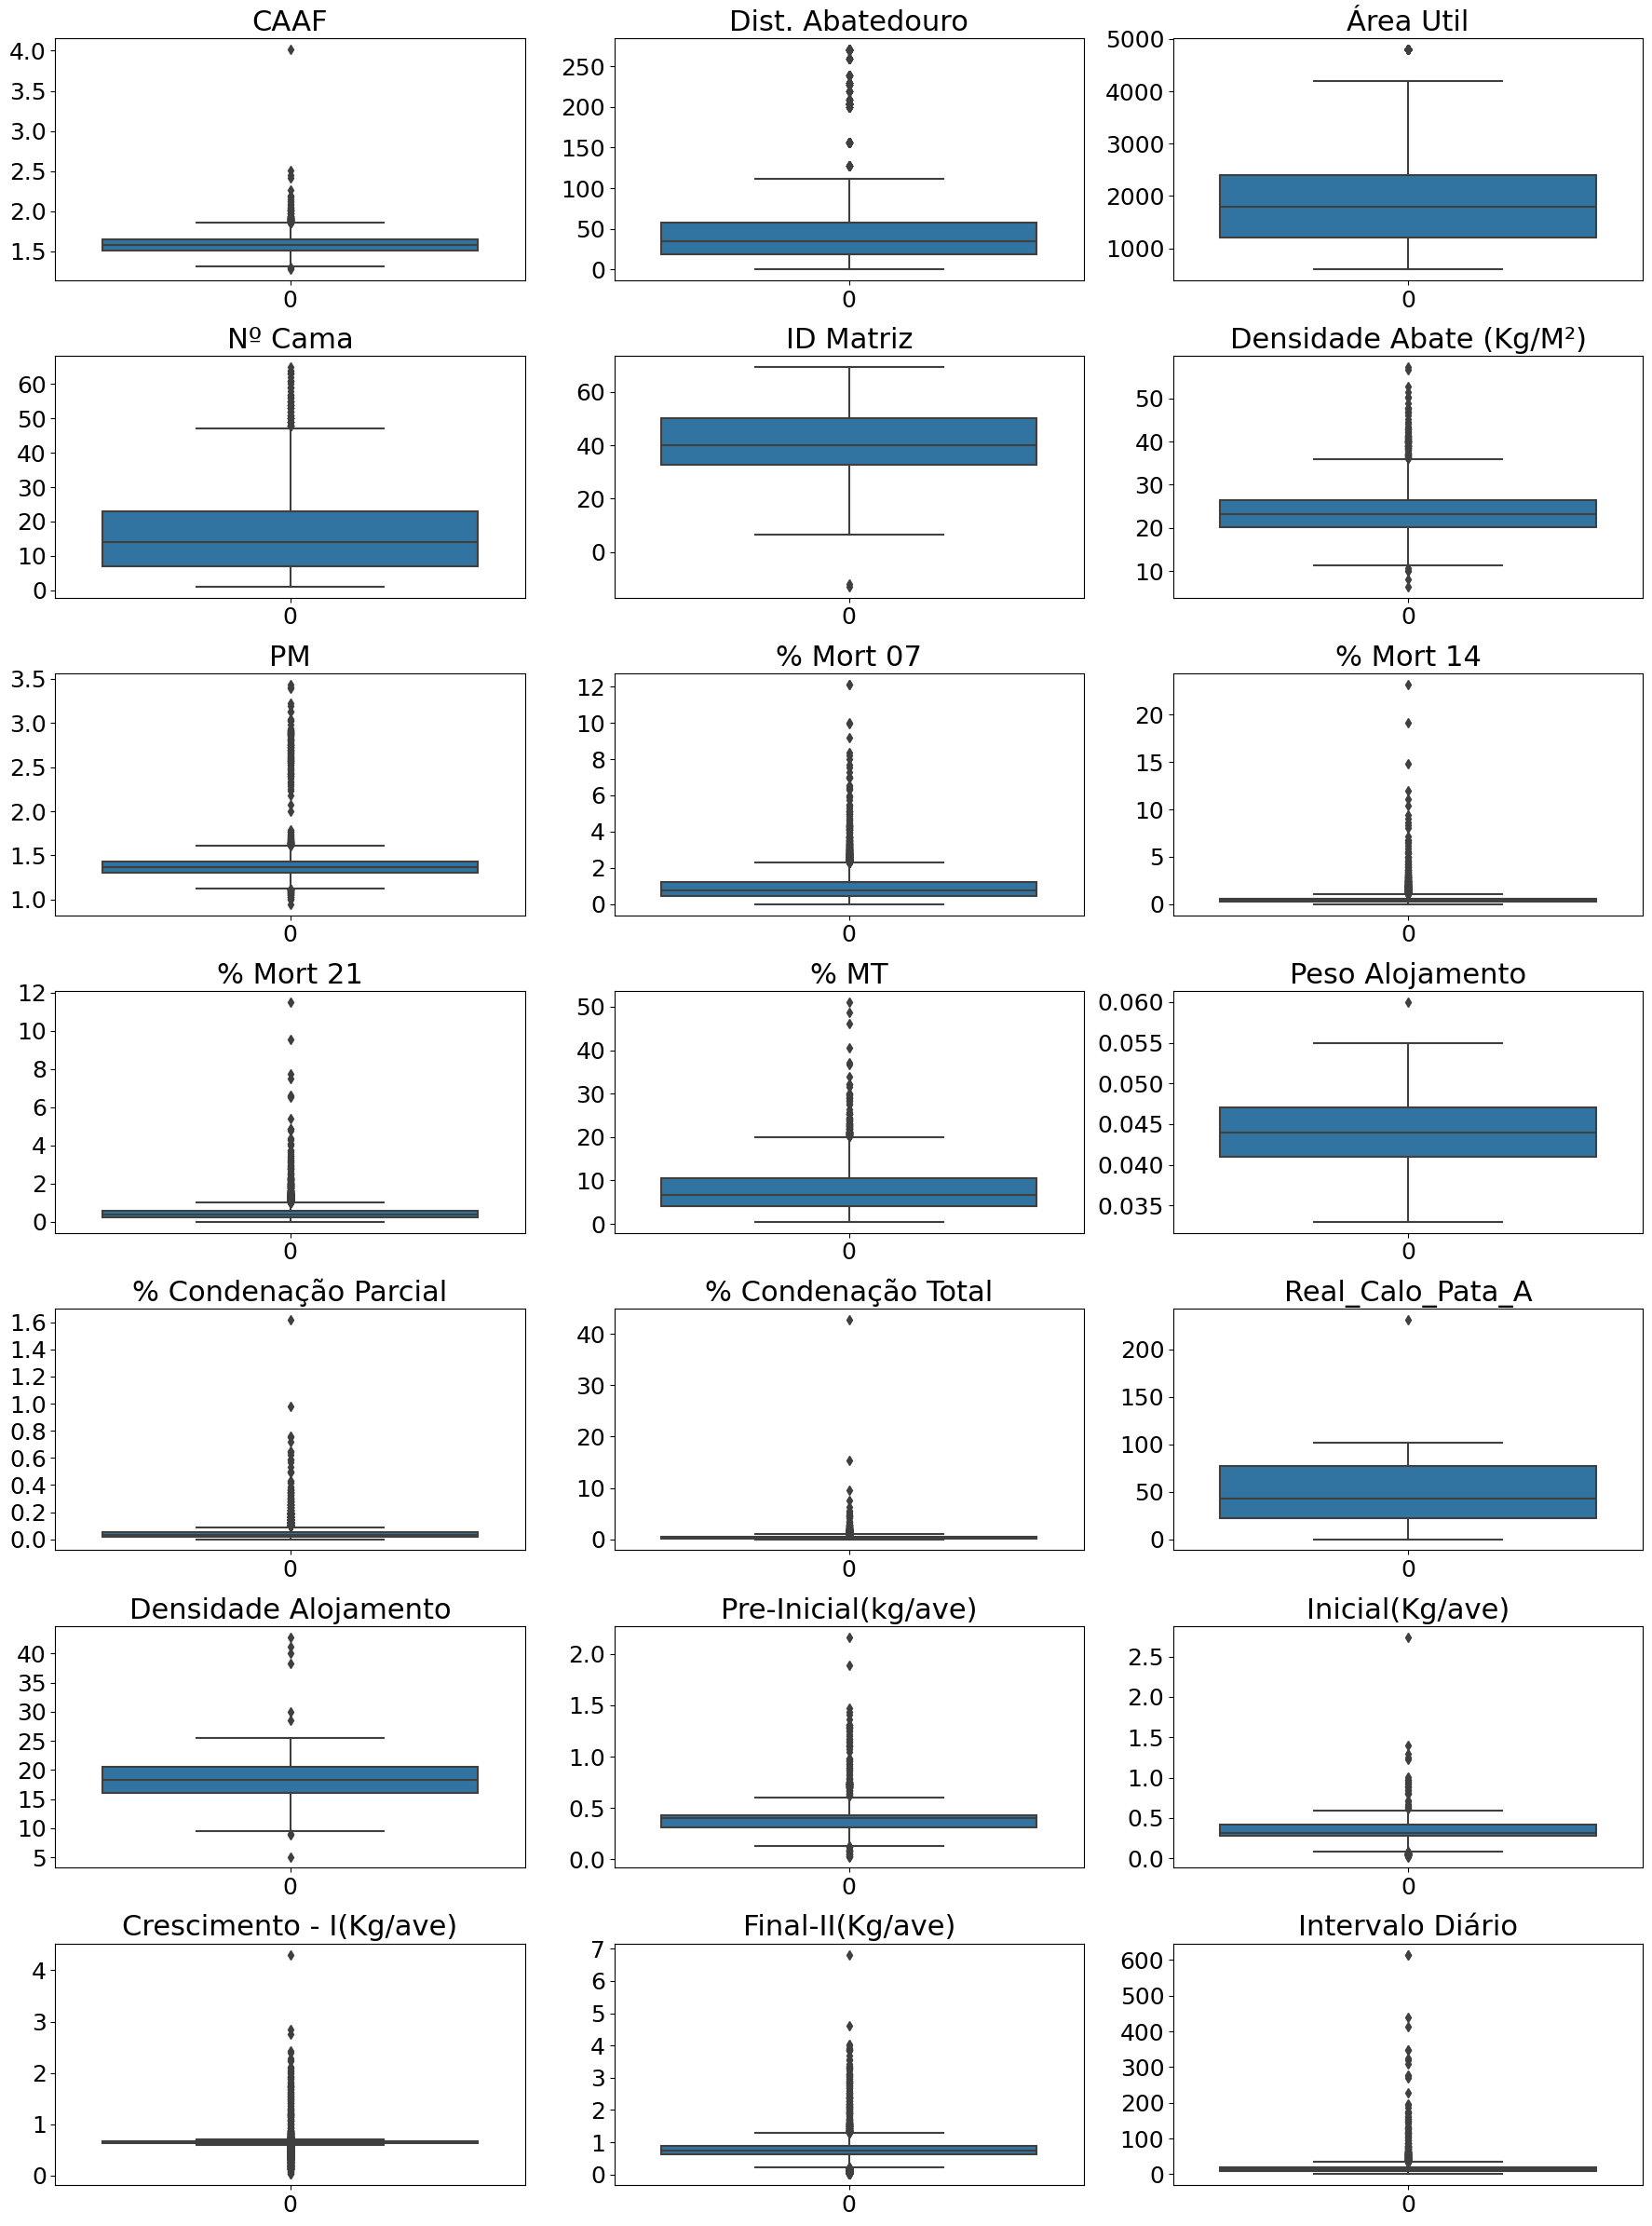

In [8]:
#Boxplot for numerical columns
numerical_columns = ['CAAF', 'Dist. Abatedouro', 'Área Util', 'Nº Cama', 'ID Matriz', 'Densidade Abate (Kg/M²)', 
                     'PM', '% Mort 07', '% Mort 14', '% Mort 21', '% MT', 'Peso Alojamento', 
                     '% Condenação Parcial', '% Condenação Total', 'Real_Calo_Pata_A', 'Densidade Alojamento', 
                     'Pre-Inicial(kg/ave)', 'Inicial(Kg/ave)', 'Crescimento - I(Kg/ave)', 'Final-II(Kg/ave)', 
                     'Intervalo Diário']

title_size = 22
label_size = 18

plt.figure(figsize=(18, 24))  
for i, col in enumerate(numerical_columns):
    plt.subplot(7, 3, i + 1)  
    sns.boxplot(data=df[col])
    plt.title(col, fontsize=title_size)
    plt.xlabel('', fontsize=label_size)
    plt.ylabel('', fontsize=label_size)
    plt.xticks(fontsize=label_size)
    plt.yticks(fontsize=label_size)

plt.tight_layout()  
plt.show()

In [9]:
#Print unique values, missing values and information counts for categorical columns
categorical_columns = ['Sexo', 'Linhagem', 'Categoria', 'Tipo Ventilação', 'Origem Incubatório', 'Origem Água', 
                       'Timer Iluminação', 'Tipo Telhado', 'Município']

counts = {}

for col in categorical_columns:
    value_counts = df[col].value_counts()
    counts[col] = value_counts

for col, value_counts in counts.items():
    num_unique = df[col].nunique()
    missing = df[col].isna().sum()
    print(f"Column {col} (unique: {num_unique}, missing: {missing})")
    for valor, contagem in value_counts.items():
        print(f"{valor}: {contagem} ")
    print()

Column Sexo (unique: 3, missing: 0)
Fêmea: 6369 
Macho: 263 
Misto: 84 

Column Linhagem (unique: 4, missing: 0)
71: 3118 
75: 3011 
74: 301 
39: 286 

Column Categoria (unique: 2, missing: 0)
FGO LV: 6600 
FGO PSDO: 116 

Column Tipo Ventilação (unique: 5, missing: 760)
Positiva: 2720 
Semi Dark: 2062 
Dark modal: 958 
Dark Produtor: 214 
Dark Produtor, Semi Dark: 2 

Column Origem Incubatório (unique: 11, missing: 0)
INCUB. AVES SANTA GEMA: 2265 
INCUB. AVES HERVAL D OESTE: 1956 
INCUB. AVES RIO DAS PEDRAS: 1577 
INCUB. AVES CAPINZAL: 833 
INCUB. AVES FAXINAL DOS GUEDES: 22 
INCUB. AVES CONCORDIA: 18 
INCUB. AVES TOLEDO: 17 
INCUB. AVES CASTRO: 12 
INCUB. AVES DOIS VIZINHOS II: 7 
INCUB. AVES MARAU: 7 
INCUB. AVES ARROIO MEIO: 2 

Column Origem Água (unique: 10, missing: 1308)
Poço Artesiano - Clorada: 3202 
Poço - Clorada: 1024 
Fonte - Clorada: 829 
Poço - não Clorada: 161 
Fonte - Não Clorada: 91 
Poço Artesiano - não Clorada: 40 
Fonte - Clorada, Poço Artesiano - Clorada: 21 
Poç

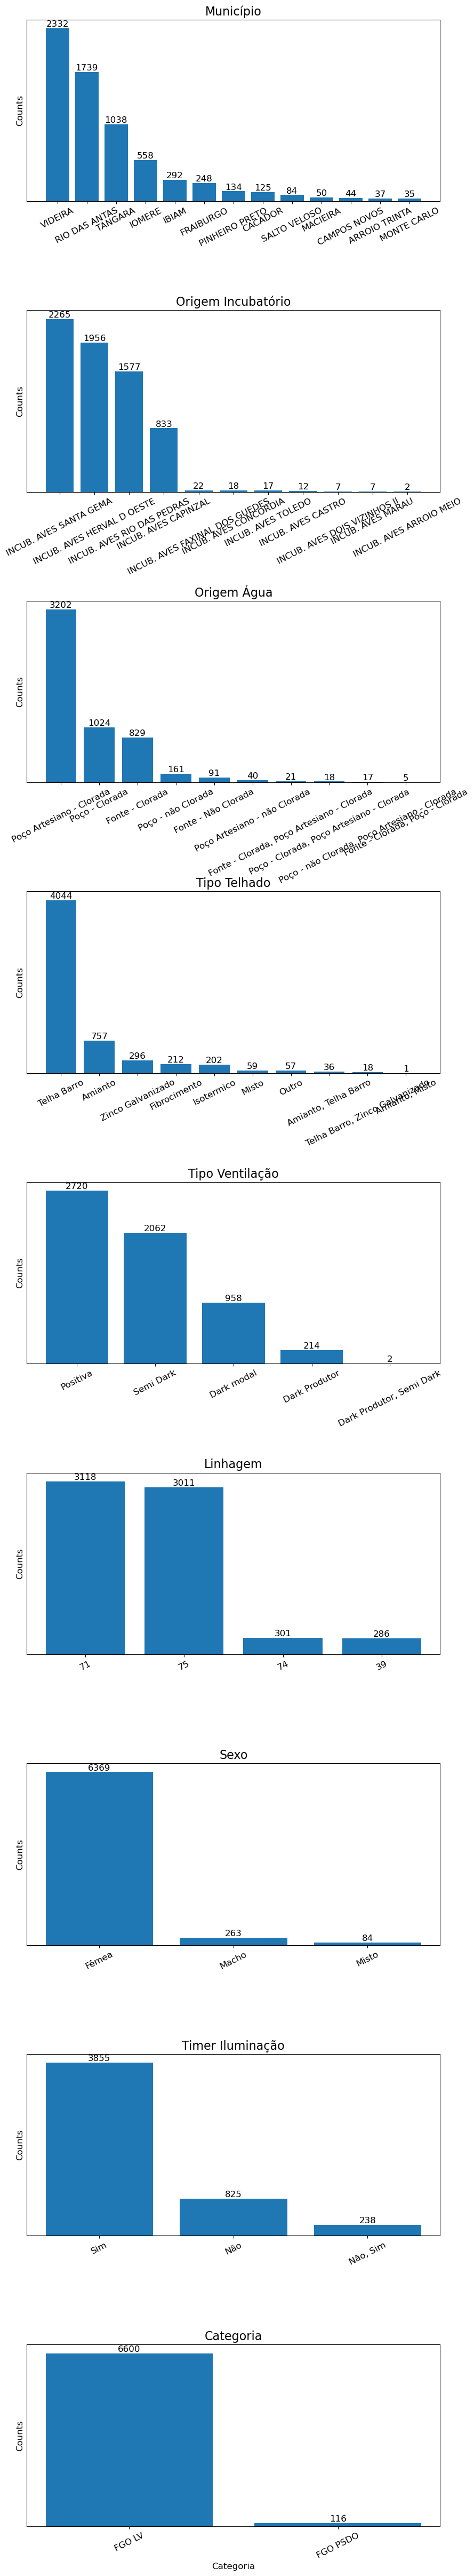

In [10]:
#Countplots for categorical variables
categorical_columns = ['Sexo', 'Linhagem', 'Categoria', 'Tipo Ventilação', 'Origem Incubatório', 'Origem Água', 
                       'Timer Iluminação', 'Tipo Telhado', 'Município']

total_bars = sum(df[col].nunique() for col in categorical_columns)

fig_height = total_bars * 1  

value_counts_dict = {}

for col in categorical_columns:
    value_counts_dict[col] = df[col].value_counts()

categorical_columns_sorted = sorted(categorical_columns, key=lambda col: len(value_counts_dict[col]), reverse=True)

fig, axs = plt.subplots(len(categorical_columns), 1, figsize=(10, fig_height), sharex=False)

title_fontsize = 16
text_fontsize = 12

for i, col in enumerate(categorical_columns_sorted):
    value_counts = value_counts_dict[col]
    infos = list(value_counts.index)
    counts = list(value_counts.values)

    bars = axs[i].bar([str(info) for info in infos], counts) 

    for bar, count in zip(bars, counts):
        axs[i].text(bar.get_x() + bar.get_width() / 2, count, str(count), ha='center', va='bottom', fontsize=text_fontsize)

    axs[i].set_yticks([])

    axs[i].set_xticks([str(info) for info in infos]) 
    axs[i].tick_params(axis='x', rotation=27, labelsize=text_fontsize)

    axs[i].set_ylabel('Counts', fontsize=text_fontsize)

    if i == len(categorical_columns) - 1:
        axs[i].set_xlabel(col, fontsize=text_fontsize)

    axs[i].set_title(col, fontsize=title_fontsize)

plt.subplots_adjust(hspace=0.6)

plt.show()

In [11]:
#3.3 PREPROCESS, ADAPT AND CLEAN VARIABLES
#Drop rows data have CAAF Above 1.9 and Extensionista NaN
df = df[df['CAAF'] <= 1.9]
df = df.dropna(subset=['Extensionista'])
#print((df['CAAF'] > 1.9).any())
#df['Extensionista'].isnull().sum()

In [12]:
#Replace empty columns in categorical for NaN
columns_to_replace_empty_NaN=['Tipo Ventilação','Tipo Telhado','Origem Água','Timer Iluminação','Extensionista']
df[columns_to_replace_empty_NaN] = df[columns_to_replace_empty_NaN].replace('nan', pd.NA)
#print(df.isnull().sum())
#print(df.head(60))

In [13]:
#Create timelapse columns
#Convert columns to datetime format
df['Data Hora Aloj'] = pd.to_datetime(df['Data Hora Aloj'], format='%d/%m/%Y %H:%M:%S')
df['Data Abate'] = pd.to_datetime(df['Data Abate'], format='%d/%m/%Y %H:%M:%S')

# Create new columns for day, month and year
df['Dia Aloj'] = df['Data Hora Aloj'].dt.day
df['Mês Aloj'] = df['Data Hora Aloj'].dt.month
df['Ano Aloj'] = df['Data Hora Aloj'].dt.year

df['Dia Abate'] = df['Data Abate'].dt.day
df['Mês Abate'] = df['Data Abate'].dt.month
df['Ano Abate'] = df['Data Abate'].dt.year

# Create new coolumn for year season
def estacao_do_ano(mes):
    if 3 <= mes <= 5:
        return 'Outono'
    elif 6 <= mes <= 8:
        return 'Inverno'
    elif 9 <= mes <= 11:
        return 'Primavera'
    else:
        return 'Verão'

df['Estação Aloj'] = df['Mês Aloj'].apply(estacao_do_ano)
df['Estação Abate'] = df['Mês Abate'].apply(estacao_do_ano)

# Create new column for day period
def periodo_do_dia(hora):
    if 6 <= hora < 12:
        return 'Manhã'
    elif 12 <= hora < 18:
        return 'Tarde'
    else:
        return 'Noite'

df['Período Aloj'] = df['Data Hora Aloj'].dt.hour.apply(periodo_do_dia)
df['Período Abate'] = df['Data Abate'].dt.hour.apply(periodo_do_dia)

#Convert columns type
columns_category = ['Dia Aloj','Mês Aloj','Ano Aloj','Dia Abate','Mês Abate','Ano Abate','Estação Aloj','Estação Abate','Período Aloj','Período Abate']
df[columns_category] = df[columns_category].astype('category')
#print(df.info())

In [14]:
# Replace incorrect information in categorical columns
# Correct 'Origem Água'
df['Origem Água'] = df['Origem Água'].replace(['Fonte - Clorada, Poço - Clorada', 
                                               'Fonte - Clorada, Poço Artesiano - Clorada'], 
                                              pd.NA)

df['Origem Água'] = df['Origem Água'].replace({'Fonte - Clorada': 'Fonte',
                                                'Fonte - Não Clorada': 'Fonte',
                                                'Poço - Clorada': 'Poço',
                                               'Poço - Clorada, Poço Artesiano - Clorada': 'Poço',
                                                'Poço - não Clorada': 'Poço',
                                               'Poço - não Clorada, Poço Artesiano - Clorada': 'Poço',
                                                'Poço Artesiano - Clorada': 'Poço',
                                                'Poço Artesiano - não Clorada': 'Poço'})
# Correct 'Tipo Ventilação'
df['Tipo Ventilação'] = df['Tipo Ventilação'].replace(['Dark Produtor, Semi Dark'], 
                                              pd.NA)
# Correct 'Tipo Telhado' 
df['Tipo Telhado'] = df['Tipo Telhado'].replace(['Amianto, Misto',
                                                  'Amianto, Telha Barro',
                                                   'Outro',
                                                   'Misto',
                                                   'Telha Barro, Zinco Galvanizado'
                                                  ], 
                                              pd.NA)

# Correct 'Timer Iluminação' 
df['Timer Iluminação'] = df['Timer Iluminação'].replace(['Não, Sim'
                                                  ], 
                                              pd.NA)

#Replace NaN by new category 'Desconhecido'
df['Timer Iluminação'] = df['Timer Iluminação'].cat.add_categories('desconhecido')
df['Timer Iluminação'].fillna('desconhecido', inplace=True)

# Replace NaN by mode
for col in ['Tipo Ventilação', 'Origem Água', 'Tipo Telhado']:
    mode_value = df[col].mode()[0] 
    df[col].fillna(mode_value, inplace=True) 

#print(df[['Origem Água','Tipo Ventilação','Tipo Telhado']].value_counts())

In [15]:
#Replace incorrect information and cleaning missing values in numerical columns
#ID Matriz - Replace wrong information by mode
df.loc[(df['ID Matriz'] < 27) | (df['ID Matriz'] > 65), 'ID Matriz'] = pd.NA
for col in ['ID Matriz']:
    mode_value = df[col].mode()[0] 
    df[col].fillna(mode_value, inplace=True)

#Pre-Inicial(kg/ave) - Replace wrong information by inferior and superior limits & Replace NaN by mode
limit_pre_2023 = 0.300
limit_pos_2023 = 0.447

condicao_1 = ((df['Data Hora Aloj'] < '2023-10-10') & ((df['Pre-Inicial(kg/ave)'] < 0.8 * limit_pre_2023) | 
                                                       (df['Pre-Inicial(kg/ave)'] > 1.2 * limit_pre_2023)))
condicao_2 = ((df['Data Hora Aloj'] >= '2023-10-10') & ((df['Pre-Inicial(kg/ave)'] < 0.8 * limit_pos_2023) | 
                                                        (df['Pre-Inicial(kg/ave)'] > 1.2 * limit_pos_2023)))

df.loc[condicao_1, 'Pre-Inicial(kg/ave)'] = df.loc[condicao_1, 'Pre-Inicial(kg/ave)'].apply(lambda x: 0.8 * limit_pre_2023 
                                                                                            if x < 0.8 * limit_pre_2023 
                                                                                            else (1.2 * limit_pre_2023 
                                                                                                  if x > 1.2 * limit_pre_2023 else x))
df.loc[condicao_2, 'Pre-Inicial(kg/ave)'] = df.loc[condicao_2, 'Pre-Inicial(kg/ave)'].apply(lambda x: 0.8 * limit_pos_2023 
                                                                                            if x < 0.8 * limit_pos_2023 
                                                                                            else (1.2 * limit_pos_2023 
                                                                                                  if x > 1.2 * limit_pos_2023 else x))
df['Pre-Inicial(kg/ave)'].fillna(df['Pre-Inicial(kg/ave)'].mode()[0], inplace=True)
df['Pre-Inicial(kg/ave)'] = df['Pre-Inicial(kg/ave)'].round(3)

#Inicial(Kg/ave) - Replace wrong information by inferior and superior limits
limit_pre_2023 = 0.387
limit_pos_2023 = 0.385

condicao_1 = ((df['Data Hora Aloj'] < '2023-10-10') & ((df['Inicial(Kg/ave)'] < 0.8 * limit_pre_2023) | 
                                                       (df['Inicial(Kg/ave)'] > 1.2 * limit_pre_2023)))
condicao_2 = ((df['Data Hora Aloj'] >= '2023-10-10') & ((df['Inicial(Kg/ave)'] < 0.8 * limit_pos_2023) | 
                                                        (df['Inicial(Kg/ave)'] > 1.2 * limit_pos_2023)))

df.loc[condicao_1, 'Inicial(Kg/ave)'] = df.loc[condicao_1, 'Inicial(Kg/ave)'].apply(lambda x: 0.8 * limit_pre_2023 
                                                                                            if x < 0.8 * limit_pre_2023 
                                                                                            else (1.2 * limit_pre_2023 
                                                                                                  if x > 1.2 * limit_pre_2023 else x))
df.loc[condicao_2, 'Inicial(Kg/ave)'] = df.loc[condicao_2, 'Inicial(Kg/ave)'].apply(lambda x: 0.8 * limit_pos_2023 
                                                                                            if x < 0.8 * limit_pos_2023 
                                                                                            else (1.2 * limit_pos_2023 
                                                                                                  if x > 1.2 * limit_pos_2023 else x))
df['Inicial(Kg/ave)'].fillna(df['Inicial(Kg/ave)'].mode()[0], inplace=True)
df['Inicial(Kg/ave)'] = df['Inicial(Kg/ave)'].round(3)

#Crescimento - I(Kg/ave) - Replace wrong information by inferior and superior limits
limit_pre_2023 = 0.899
limit_pos_2023 = 0.638

condicao_1 = ((df['Data Hora Aloj'] < '2023-10-10') & ((df['Crescimento - I(Kg/ave)'] < 0.8 * limit_pre_2023) | 
                                                       (df['Crescimento - I(Kg/ave)'] > 1.2 * limit_pre_2023)))
condicao_2 = ((df['Data Hora Aloj'] >= '2023-10-10') & ((df['Crescimento - I(Kg/ave)'] < 0.8 * limit_pos_2023) | 
                                                        (df['Crescimento - I(Kg/ave)'] > 1.2 * limit_pos_2023)))

df.loc[condicao_1, 'Crescimento - I(Kg/ave)'] = df.loc[condicao_1, 'Crescimento - I(Kg/ave)'].apply(lambda x: 0.8 * limit_pre_2023 
                                                                                            if x < 0.8 * limit_pre_2023 
                                                                                            else (1.2 * limit_pre_2023 
                                                                                                  if x > 1.2 * limit_pre_2023 else x))
df.loc[condicao_2, 'Crescimento - I(Kg/ave)'] = df.loc[condicao_2, 'Crescimento - I(Kg/ave)'].apply(lambda x: 0.8 * limit_pos_2023 
                                                                                            if x < 0.8 * limit_pos_2023 
                                                                                            else (1.2 * limit_pos_2023 
                                                                                                  if x > 1.2 * limit_pos_2023 else x))
df['Crescimento - I(Kg/ave)'].fillna(df['Crescimento - I(Kg/ave)'].mode()[0], inplace=True)
df['Crescimento - I(Kg/ave)'] = df['Crescimento - I(Kg/ave)'].round(3)

#Final-II(Kg/ave) - Replace wrong information by inferior and superior limits
limit_pre_2023 = 0.668
limit_pos_2023 = 0.668

condicao_1 = ((df['Data Hora Aloj'] < '2023-10-10') & ((df['Final-II(Kg/ave)'] < 0.8 * limit_pre_2023) | 
                                                       (df['Final-II(Kg/ave)'] > 1.2 * limit_pre_2023)))
condicao_2 = ((df['Data Hora Aloj'] >= '2023-10-10') & ((df['Final-II(Kg/ave)'] < 0.8 * limit_pos_2023) | 
                                                        (df['Final-II(Kg/ave)'] > 1.2 * limit_pos_2023)))

df.loc[condicao_1, 'Final-II(Kg/ave)'] = df.loc[condicao_1, 'Final-II(Kg/ave)'].apply(lambda x: 0.8 * limit_pre_2023 
                                                                                            if x < 0.8 * limit_pre_2023 
                                                                                            else (1.2 * limit_pre_2023 
                                                                                                  if x > 1.2 * limit_pre_2023 else x))
df.loc[condicao_2, 'Final-II(Kg/ave)'] = df.loc[condicao_2, 'Final-II(Kg/ave)'].apply(lambda x: 0.8 * limit_pos_2023 
                                                                                            if x < 0.8 * limit_pos_2023 
                                                                                            else (1.2 * limit_pos_2023 
                                                                                                  if x > 1.2 * limit_pos_2023 else x))
df['Final-II(Kg/ave)'].fillna(df['Final-II(Kg/ave)'].mode()[0], inplace=True)
df['Final-II(Kg/ave)'] = df['Final-II(Kg/ave)'].round(3)

#% MT
df.loc[df['% MT'] < 1, '% MT'] = 1
df.loc[df['% MT'] > 15, '% MT'] = 15
#print((df['% MT'] <1).any())

# % Mort 07 , % Mort 14 , % Mort 21
colunas = ['% Mort 07', '% Mort 14', '% Mort 21']
for coluna in colunas:
    df.loc[df[coluna] < 0.3, coluna] = 0.3 
#print((df['% Mort 07'] <0.3).any())   

# Densidade Alojamento
df.loc[df['Densidade Alojamento'] < 13, 'Densidade Alojamento'] = 13
df.loc[df['Densidade Alojamento'] > 25, 'Densidade Alojamento'] = 25

# Densidade Abate (Kg/M²)
df.loc[df['Densidade Abate (Kg/M²)'] < 18, 'Densidade Abate (Kg/M²)'] = 18
df.loc[df['Densidade Abate (Kg/M²)'] > 30, 'Densidade Abate (Kg/M²)'] = 30

# Real_Calo_Pata_A
df.loc[df['Real_Calo_Pata_A'] > 100, 'Real_Calo_Pata_A'] = 100

# ID Abate
df.loc[df['ID Abate'] < 24, 'ID Abate'] = 24
df.loc[df['ID Abate'] > 35, 'ID Abate'] = 35

# % Condenação Total
df.loc[df['% Condenação Total'] < 0.1, '% Condenação Total'] = 0.1
df.loc[df['% Condenação Total'] > 20, '% Condenação Total'] = 20

# % Condenação Parcial
df.loc[df['% Condenação Parcial'] < 0.1, '% Condenação Parcial'] = 0.1

# Dist. Abatedouro - 0 values by mode of the city
city_modes = df.groupby('Município')['Dist. Abatedouro'].apply(lambda x: x.mode().iloc[0])
for city, mode_distance in city_modes.items():
    df.loc[(df['Dist. Abatedouro'] == 0) & (df['Município'] == city), 'Dist. Abatedouro'] = mode_distance
#df.loc[(df['Dist. Abatedouro'] == 0), 'Dist. Abatedouro'] = pd.NA
#print((df['Dist. Abatedouro'] ==0).any()) 

C:\Users\502694\AppData\Local\Temp\ipykernel_15672\3811057524.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  city_modes = df.groupby('Município')['Dist. Abatedouro'].apply(lambda x: x.mode().iloc[0])


In [16]:
# Group informations in the columns
# ID Matriz 5 per 5
limites = list(range(27, 71, 5))
rotulos = [f"{inicio} a {inicio + 4} semanas" for inicio in limites[:-1]]
df['ID Matriz'] = pd.cut(df['ID Matriz'], bins=limites, labels=rotulos, right=False)
#print((df['ID Matriz'].head(30)))
#print(df.info())

#Peso Alojamento 3 per 3
limites_peso = list(np.arange(0.030, 0.061, 0.003))
rotulos_peso = [f"{round(inicio,3)} a {round(inicio + 0.002, 3)} Kg" for inicio in limites_peso[:-1]]
df['Peso Alojamento'] = pd.cut(df['Peso Alojamento'], bins=limites_peso, labels=rotulos_peso, right=False)
#print(df['Peso Alojamento'].head(30))
#print(df['Peso Alojamento'].info())

# Área Útil 
limites_area_util = [0, 1200, 1800, 2400, 3000, 6000]
rotulos_area_util = ['<=1200 m²', '1201 a 1800 m²', '1801 a 2400 m²', '2401 a 3000 m²', '3001 a 6000 m²']
df['Área Util'] = pd.cut(df['Área Util'], bins=limites_area_util, labels=rotulos_area_util, right=False)
#print(df['Área Util'].head(30))
#print(df['Área Util'].info())

#Nº camas
limites_camas = list(range(1, df['Nº Cama'].max() + 4, 3))
rotulos_camas = [f"{inicio} a {inicio + 2} camas" for inicio in range(1, df['Nº Cama'].max() + 1, 3)]
df['Nº Cama'] = pd.cut(df['Nº Cama'], bins=limites_camas, labels=rotulos_camas, right=False)
#print(df['Área Util'].head(30))
#print(df['Área Util'].info())

# Intervalo Diário 
limites_intervalo = [0, 6, 11, 16, df['Intervalo Diário'].max() + 1]
rotulos_intervalo = ['Até 6 dias', '7 a 11 dias', '12 a 16 dias', 'Acima de 17 dias']
df['Intervalo Diário'] = pd.cut(df['Intervalo Diário'], bins=limites_intervalo, labels=rotulos_intervalo, right=False)
#print(df['Intervalo Diário'].head(30))
#print(df['Intervalo Diário'].info())

# Real_Calo_Pata_A
limites_real_calo = list(range(0, 101, 5))
limites_real_calo.append(np.inf)  
rotulos_real_calo = [f"{inicio} a {inicio + 4} %" for inicio in limites_real_calo[:-1]]
rotulos_real_calo[-1] = '100 %' 
df['Real_Calo_Pata_A'] = pd.cut(df['Real_Calo_Pata_A'], bins=limites_real_calo, labels=rotulos_real_calo, right=False)

In [17]:
#Understand numerical columns to define scaling method
numerical_columns = ['Dist. Abatedouro', 'Densidade Abate (Kg/M²)', 'PM', 
                     '% Mort 07', '% Mort 14', '% Mort 21', '% MT', 
                     '% Condenação Parcial', '% Condenação Total', 
                     'Densidade Alojamento', 'ID Abate', 'Pre-Inicial(kg/ave)', 
                     'Inicial(Kg/ave)', 'Crescimento - I(Kg/ave)', 'Final-II(Kg/ave)']

min_max_values = {}
for column_name in numerical_columns:
    min_value = df[column_name].min()
    max_value = df[column_name].max()
    min_max_values[column_name] = {'min': min_value, 'max': max_value}

for column_name, values in min_max_values.items():
    print(f"Column '{column_name}': Min = {values['min']}, Max = {values['max']}")
    
# Check for missing values in each column
missing_values = df[numerical_columns].isnull().sum()
print("\nMissing values in numerical columns:")
print(missing_values)

Column 'Dist. Abatedouro': Min = 3.0, Max = 271.0
Column 'Densidade Abate (Kg/M²)': Min = 18.0, Max = 30.0
Column 'PM': Min = 0.999, Max = 3.437
Column '% Mort 07': Min = 0.3, Max = 12.11
Column '% Mort 14': Min = 0.3, Max = 23.18
Column '% Mort 21': Min = 0.3, Max = 11.5
Column '% MT': Min = 1.0, Max = 15.0
Column '% Condenação Parcial': Min = 0.1, Max = 0.76
Column '% Condenação Total': Min = 0.1, Max = 15.29
Column 'Densidade Alojamento': Min = 13.0, Max = 25.0
Column 'ID Abate': Min = 24.0, Max = 35.0
Column 'Pre-Inicial(kg/ave)': Min = 0.24, Max = 0.536
Column 'Inicial(Kg/ave)': Min = 0.308, Max = 0.464
Column 'Crescimento - I(Kg/ave)': Min = 0.51, Max = 1.079
Column 'Final-II(Kg/ave)': Min = 0.534, Max = 0.802

Missing values in numerical columns:
Dist. Abatedouro           0
Densidade Abate (Kg/M²)    0
PM                         0
% Mort 07                  0
% Mort 14                  0
% Mort 21                  0
% MT                       0
% Condenação Parcial       0
% Co

In [18]:
# Scaling numerical variables
scaling_methods = {
    'Dist. Abatedouro': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to wide range
    'Densidade Abate (Kg/M²)': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    'PM': StandardScaler(),  # StandardScaler chosen for standardization to center around 0 with a standard deviation of 1
    '% Mort 07': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    '% Mort 14': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    '% Mort 21': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    '% MT': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    'ID Abate': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to wide range
    '% Condenação Parcial': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    '% Condenação Total': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    'Densidade Alojamento': MinMaxScaler(),  # MinMaxScaler chosen to scale between 0 and 1 due to bounded values
    'Pre-Inicial(kg/ave)': StandardScaler(),  # StandardScaler chosen for standardization to center around 0 with a standard deviation of 1
    'Inicial(Kg/ave)': StandardScaler(),  # StandardScaler chosen for standardization to center around 0 with a standard deviation of 1
    'Crescimento - I(Kg/ave)': StandardScaler(),  # StandardScaler chosen for standardization to center around 0 with a standard deviation of 1
    'Final-II(Kg/ave)': StandardScaler()  # StandardScaler chosen for standardization to center around 0 with a standard deviation of 1
}

scaled_cols = [col + '_scaled' for col in numerical_columns]

for column_name, scaler in scaling_methods.items():
   df[column_name + '_scaled'] = scaler.fit_transform(df[[column_name]])

print(df[scaled_cols].head())

   Dist. Abatedouro_scaled  Densidade Abate (Kg/M²)_scaled  PM_scaled  \
0                 0.126866                        0.704167  -0.383681   
1                 0.570896                        0.892500   0.197205   
2                 0.570896                        0.995833   0.059905   
3                 0.093284                        0.694167   0.086309   
4                 0.085821                        0.469167   0.741126   

   % Mort 07_scaled  % Mort 14_scaled  % Mort 21_scaled  % MT_scaled  \
0          0.005080          0.003934          0.001786     0.017493   
1          0.078747          0.007430          0.004464     0.084979   
2          0.066046          0.008741          0.008036     0.080664   
3          0.022862          0.003934          0.000000     0.035243   
4          0.033870          0.006119          0.021429     0.153643   

   % Condenação Parcial_scaled  % Condenação Total_scaled  \
0                     0.000000                   0.003950   
1     

In [19]:
#Understand categorical columns to define encoding method
categorical_columns = ['Sexo', 'Linhagem', 'Categoria', 'Tipo Ventilação', 'Área Util', 'Nº Cama', 'Origem Incubatório', 
                       'ID Matriz', 'Peso Alojamento', 'Real_Calo_Pata_A', 'Origem Água', 'Timer Iluminação', 'Tipo Telhado', 
                       'Extensionista', 'Nº Fornecedor', 'Município', 'Intervalo Diário', 'Mês Aloj', 
                       'Mês Abate', 'Estação Aloj', 'Estação Abate', 'Período Aloj', 
                       'Período Abate']

unique_values_counts = {}
for column_name in categorical_columns:
    unique_values_counts[column_name] = df[column_name].nunique()

for column_name, count in unique_values_counts.items():
    print(f"Column '{column_name}' has {count} unique values.")
    
# Check for missing values in each column
missing_values = df[categorical_columns].isnull().sum()
print("\nMissing values in categorical columns:")
print(missing_values)

Column 'Sexo' has 3 unique values.
Column 'Linhagem' has 4 unique values.
Column 'Categoria' has 2 unique values.
Column 'Tipo Ventilação' has 4 unique values.
Column 'Área Util' has 5 unique values.
Column 'Nº Cama' has 22 unique values.
Column 'Origem Incubatório' has 11 unique values.
Column 'ID Matriz' has 8 unique values.
Column 'Peso Alojamento' has 9 unique values.
Column 'Real_Calo_Pata_A' has 21 unique values.
Column 'Origem Água' has 2 unique values.
Column 'Timer Iluminação' has 3 unique values.
Column 'Tipo Telhado' has 5 unique values.
Column 'Extensionista' has 19 unique values.
Column 'Nº Fornecedor' has 312 unique values.
Column 'Município' has 13 unique values.
Column 'Intervalo Diário' has 4 unique values.
Column 'Mês Aloj' has 12 unique values.
Column 'Mês Abate' has 12 unique values.
Column 'Estação Aloj' has 4 unique values.
Column 'Estação Abate' has 4 unique values.
Column 'Período Aloj' has 3 unique values.
Column 'Período Abate' has 3 unique values.

Missing va

In [20]:
# Encoding categorical variables
# Label Encoding
label_encoder = LabelEncoder()
df['Extensionista_encoded'] = label_encoder.fit_transform(df['Extensionista'])
df['Município_encoded'] = label_encoder.fit_transform(df['Município'])
df['Nº Fornecedor_encoded'] = label_encoder.fit_transform(df['Nº Fornecedor'])

#print(df.head())

In [21]:
# One-hot Encoding
categorical_columns_one_hot = ['Sexo', 'Linhagem', 'Categoria', 'Tipo Ventilação', 'Origem Incubatório', 'Origem Água', 
                       'Tipo Telhado', 'Timer Iluminação']
label_encoders = {}
for col in categorical_columns_one_hot:
    label_encoders[col] = LabelEncoder()
    df[col + '_encoded'] = label_encoders[col].fit_transform(df[col])

#print(df.head())
#print(df[['Sexo', 'Linhagem', 'Categoria', 'Tipo Ventilação', 'Origem Incubatório', 'Origem Água', 'Tipo Telhado','Timer Iluminação']].head(60))
#print(df.groupby('Categoria')['Nº Lote'].count())                                                                                                                            

In [22]:
# Ordinal Encoding - Replace missing values with 100 and mode
ordinal_cols = ['Área Util', 'Nº Cama', 'ID Matriz', 'Peso Alojamento', 'Real_Calo_Pata_A', 'Intervalo Diário', 'Mês Aloj', 
               'Mês Abate', 'Estação Aloj', 'Estação Abate', 'Período Aloj', 'Período Abate']
ordinal_mapping = [
    ['<=1200 m²', '1201 a 1800 m²', '1801 a 2400 m²', '2401 a 3000 m²', '3001 a 6000 m²'],
    ['1 a 3 camas', '4 a 6 camas', '7 a 9 camas', '10 a 12 camas', '13 a 15 camas', '16 a 18 camas', '19 a 21 camas', 
     '22 a 24 camas', '25 a 27 camas', '28 a 30 camas', '31 a 33 camas', '34 a 36 camas', '37 a 39 camas', '40 a 42 camas', 
     '43 a 45 camas', '46 a 48 camas', '49 a 51 camas', '52 a 54 camas', '55 a 57 camas', '58 a 60 camas', '61 a 63 camas', 
     '64 a 66 camas'],
    ['27 a 31 semanas', '32 a 36 semanas', '37 a 41 semanas', '42 a 46 semanas', '47 a 51 semanas', '52 a 56 semanas', '57 a 61 semanas',
    '62 a 66 semanas'],
    ['0.03 a 0.032 Kg','0.033 a 0.035 Kg', '0.036 a 0.038 Kg', '0.039 a 0.041 Kg', '0.042 a 0.044 Kg', '0.045 a 0.047 Kg',
     '0.048 a 0.05 Kg', '0.051 a 0.053 Kg', '0.054 a 0.056 Kg', '0.057 a 0.059 Kg'],
    ['0 a 4 %', '5 a 9 %', '10 a 14 %', '15 a 19 %', '20 a 24 %', '25 a 29 %', '30 a 34 %', '35 a 39 %', '40 a 44 %', '45 a 49 %', 
     '50 a 54 %', '55 a 59 %', '60 a 64 %', '65 a 69 %', '70 a 74 %', '75 a 79 %', '80 a 84 %', '85 a 89 %', '90 a 94 %', '95 a 99 %',
     '100 %'],
    ['Até 6 dias', '7 a 11 dias', '12 a 16 dias', 'Acima de 17 dias'],
    ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
    ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
    ['Verão', 'Outono', 'Inverno', 'Primavera'],
    ['Verão', 'Outono', 'Inverno', 'Primavera'],
    ['Manhã', 'Tarde', 'Noite'],
    ['Manhã', 'Tarde', 'Noite']
]

# Criando um codificador ordinal
ordinal_encoder = OrdinalEncoder(categories=ordinal_mapping)

# Criando novas colunas com sufixo "_encoded"
encoded_cols = [col + '_encoded' for col in ordinal_cols]
df[encoded_cols] = df[ordinal_cols]  # Copiando as colunas originais para as novas colunas

# Substituindo as informações das colunas originais pelos valores codificados
df[encoded_cols] = ordinal_encoder.fit_transform(df[encoded_cols])

#print(df.head())

In [23]:
numerical_columns_scaled = ['Dist. Abatedouro_scaled', 'Densidade Abate (Kg/M²)_scaled', 'ID Abate_scaled', 'PM_scaled', 
                     '% Mort 07_scaled', '% Mort 14_scaled', '% Mort 21_scaled', '% MT_scaled', 
                     '% Condenação Parcial_scaled', '% Condenação Total_scaled', 
                     'Densidade Alojamento_scaled', 'Pre-Inicial(kg/ave)_scaled', 
                     'Inicial(Kg/ave)_scaled', 'Crescimento - I(Kg/ave)_scaled', 'Final-II(Kg/ave)_scaled']
print(df[numerical_columns_scaled].head())

   Dist. Abatedouro_scaled  Densidade Abate (Kg/M²)_scaled  ID Abate_scaled  \
0                 0.126866                        0.704167         0.127273   
1                 0.570896                        0.892500         0.200000   
2                 0.570896                        0.995833         0.190909   
3                 0.093284                        0.694167         0.200000   
4                 0.085821                        0.469167         0.309091   

   PM_scaled  % Mort 07_scaled  % Mort 14_scaled  % Mort 21_scaled  \
0  -0.383681          0.005080          0.003934          0.001786   
1   0.197205          0.078747          0.007430          0.004464   
2   0.059905          0.066046          0.008741          0.008036   
3   0.086309          0.022862          0.003934          0.000000   
4   0.741126          0.033870          0.006119          0.021429   

   % MT_scaled  % Condenação Parcial_scaled  % Condenação Total_scaled  \
0     0.017493                

Mean Squared Error (MSE): 0.00251
Root Mean Squared Error (RMSE): 0.0501
Coefficient of Determination (R²): 0.76056
Mean Absolute Error (MAE): 0.038


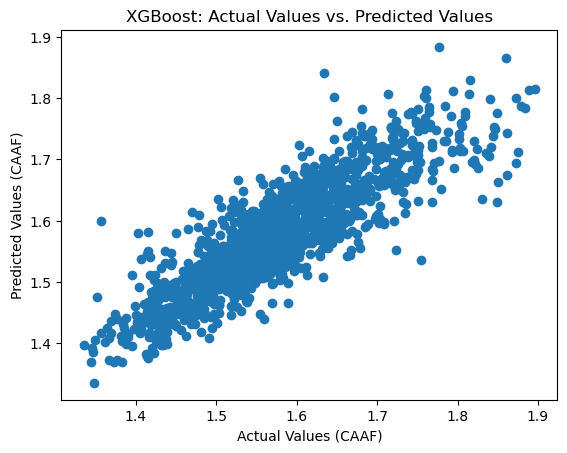

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'learning_rate': 0.041204, 'max_depth': 5, 'n_estimators': 136}
Comparison of Model Performance Before and After Tuning:
                    Metric  Before Tuning  After Tuning
0       Mean Squared Error        0.00251      0.002604
1  Root Mean Squared Error        0.05010      0.051029
2                R-squared        0.76056      0.751851
3      Mean Absolute Error        0.03800      0.037687


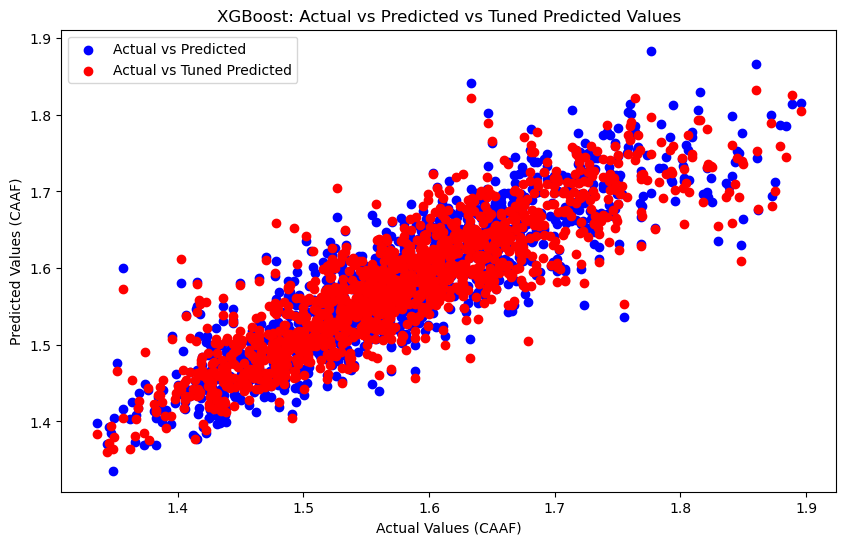

In [24]:
#3.4 MODEL AND 3.5 RESULTS
#Run XGBoost Model
#Set numerical and categorical columns
numerical_columns_scaled = ['Dist. Abatedouro_scaled', 'Densidade Abate (Kg/M²)_scaled', 'PM_scaled', 
                     '% Mort 07_scaled', '% Mort 14_scaled', '% Mort 21_scaled', 'ID Abate_scaled', '% MT_scaled', 
                     '% Condenação Parcial_scaled', '% Condenação Total_scaled', 
                     'Densidade Alojamento_scaled', 'Pre-Inicial(kg/ave)_scaled', 
                     'Inicial(Kg/ave)_scaled', 'Crescimento - I(Kg/ave)_scaled', 'Final-II(Kg/ave)_scaled']

categorical_columns_encoded = ['Sexo_encoded', 'Linhagem_encoded', 'Categoria_encoded', 'Tipo Ventilação_encoded', 'Área Util_encoded', 'Nº Cama_encoded', 
                       'Origem Incubatório_encoded', 'ID Matriz_encoded', 'Peso Alojamento_encoded', 'Real_Calo_Pata_A_encoded', 
                       'Origem Água_encoded', 'Timer Iluminação_encoded', 'Tipo Telhado_encoded', 'Extensionista_encoded', 'Nº Fornecedor_encoded', 
                       'Município_encoded', 'Intervalo Diário_encoded', 'Mês Aloj_encoded', 'Mês Abate_encoded', 'Estação Aloj_encoded', 
                       'Estação Abate_encoded', 'Período Aloj_encoded', 'Período Abate_encoded']
y = df['CAAF']

# Concatenating the numeric and categorical columns
numerical_columns_array = df[numerical_columns_scaled].values
categorical_columns_array = df[categorical_columns_encoded].values
X = np.concatenate((numerical_columns_array, categorical_columns_array), axis=1)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating an XGBoost regression model
model = xgb.XGBRegressor()

# Training the model with the training data
model.fit(X_train, y_train)

# Making predictions with the test data
y_pred = model.predict(X_test)

# Calculating regression metrics
mse = mean_squared_error(y_test, y_pred).round(5)
rmse = np.sqrt(mse).round(5)
r2 = r2_score(y_test, y_pred).round(5)
mae = mean_absolute_error(y_test, y_pred).round(5)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Coefficient of Determination (R²): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values (CAAF)')
plt.ylabel('Predicted Values (CAAF)')
plt.title('XGBoost: Actual Values vs. Predicted Values')
plt.show()

#Tuning the model
param_dist = {
    'n_estimators': randint(50, 150), 
    'max_depth': randint(3, 7),        
    'learning_rate': uniform(0.01, 0.2) 
}

base_model = XGBRegressor()

random_search = RandomizedSearchCV(estimator=base_model, 
                                   param_distributions=param_dist, 
                                   n_iter=10,  
                                   cv=3,       
                                   scoring='neg_mean_squared_error',  
                                   random_state=42, 
                                   verbose=2, 
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_params['learning_rate'] = round(best_params['learning_rate'], 6)  
print("Best Hyperparameters:", best_params)

best_model = random_search.best_estimator_

y_pred_tuned = best_model.predict(X_test)

# After Tuning Metrics Calculation
mse_tuned = round(mean_squared_error(y_test, y_pred_tuned),6)
rmse_tuned = round(np.sqrt(mse_tuned),6)
r2_tuned = round(r2_score(y_test, y_pred_tuned),6)
mae_tuned = round(mean_absolute_error(y_test, y_pred_tuned),6)

data = {
    "Metric": ["Mean Squared Error", "Root Mean Squared Error", "R-squared", "Mean Absolute Error"],
    "Before Tuning": [mse, rmse, r2, mae],
    "After Tuning": [mse_tuned, rmse_tuned, r2_tuned, mae_tuned]
}

comparison_df = pd.DataFrame(data)

print("Comparison of Model Performance Before and After Tuning:")
print(comparison_df)

plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')

plt.scatter(y_test, y_pred_tuned, color='red', label='Actual vs Tuned Predicted')

plt.xlabel('Actual Values (CAAF)')
plt.ylabel('Predicted Values (CAAF)')
plt.title('XGBoost: Actual vs Predicted vs Tuned Predicted Values')
plt.legend()
plt.show()

In [25]:
#Perform cross-validation
# Define the number of folds for cross-validation
num_folds = 5

# Perform cross-validation
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation and get predictions
cv_predictions = cross_val_predict(best_model, X, y, cv=kfold)

# Calculate MSE, RMSE, MAE, and R²
mse_cross = round(mean_squared_error(y, cv_predictions),6)
rmse_cross = round(np.sqrt(mse),6)
mae_cross = round(mean_absolute_error(y, cv_predictions),6)
r2_cross = round(r2_score(y, cv_predictions),6)

print("Metrics after cross validation")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Metrics after cross validation
Mean Squared Error (MSE): 0.00251
Root Mean Squared Error (RMSE): 0.0501
Mean Absolute Error (MAE): 0.038
R-squared (R²): 0.76056


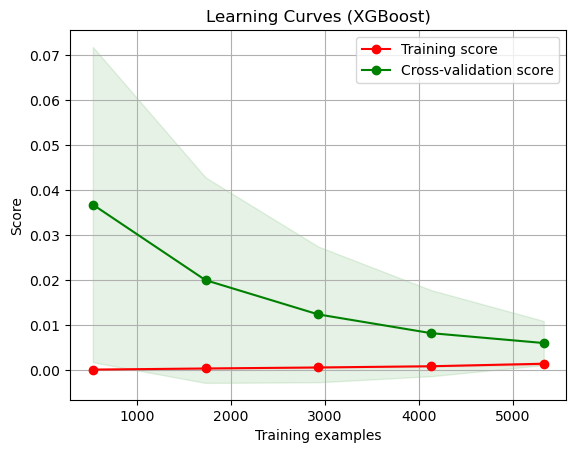

In [26]:
#Learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (XGBoost)"
plot_learning_curve(best_model, title, X, y, cv=5, n_jobs=-1)

plt.show()

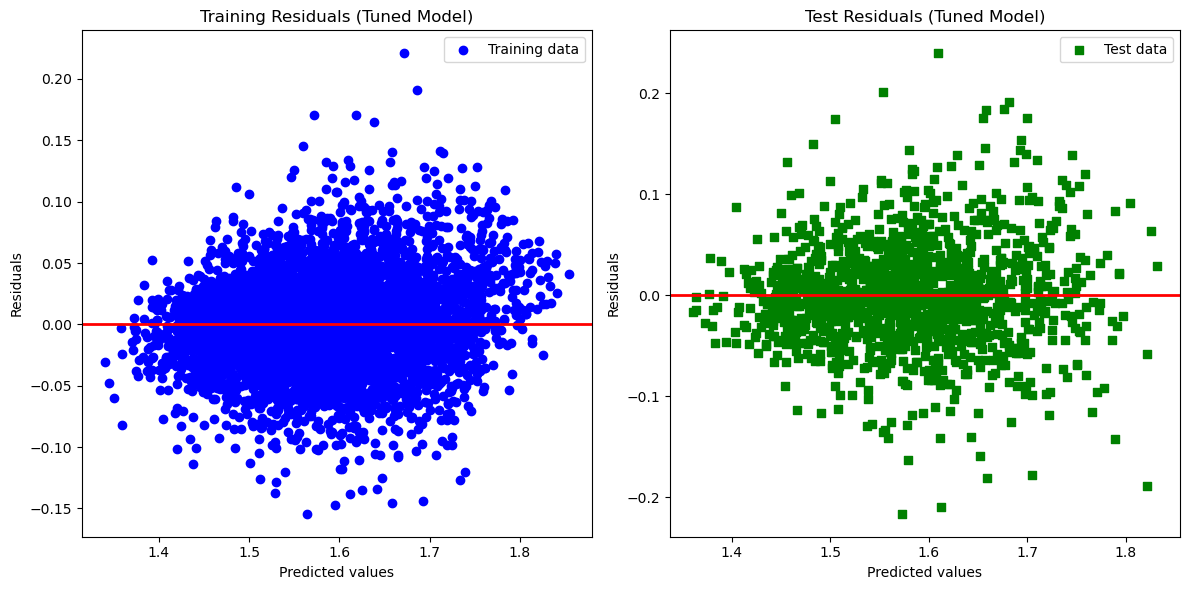

In [27]:
# Make predictions with the tuned model
y_train_pred_tuned = best_model.predict(X_train)
y_test_pred_tuned = best_model.predict(X_test)

train_residuals_tuned = y_train - y_train_pred_tuned
test_residuals_tuned = y_test - y_test_pred_tuned

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train_pred_tuned, train_residuals_tuned, color='blue', marker='o', label='Training data')
plt.axhline(y=0, color='red', linestyle='-', linewidth=2)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Training Residuals (Tuned Model)')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred_tuned, test_residuals_tuned, color='green', marker='s', label='Test data')
plt.axhline(y=0, color='red', linestyle='-', linewidth=2)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Test Residuals (Tuned Model)')
plt.legend()

plt.tight_layout()
plt.show()

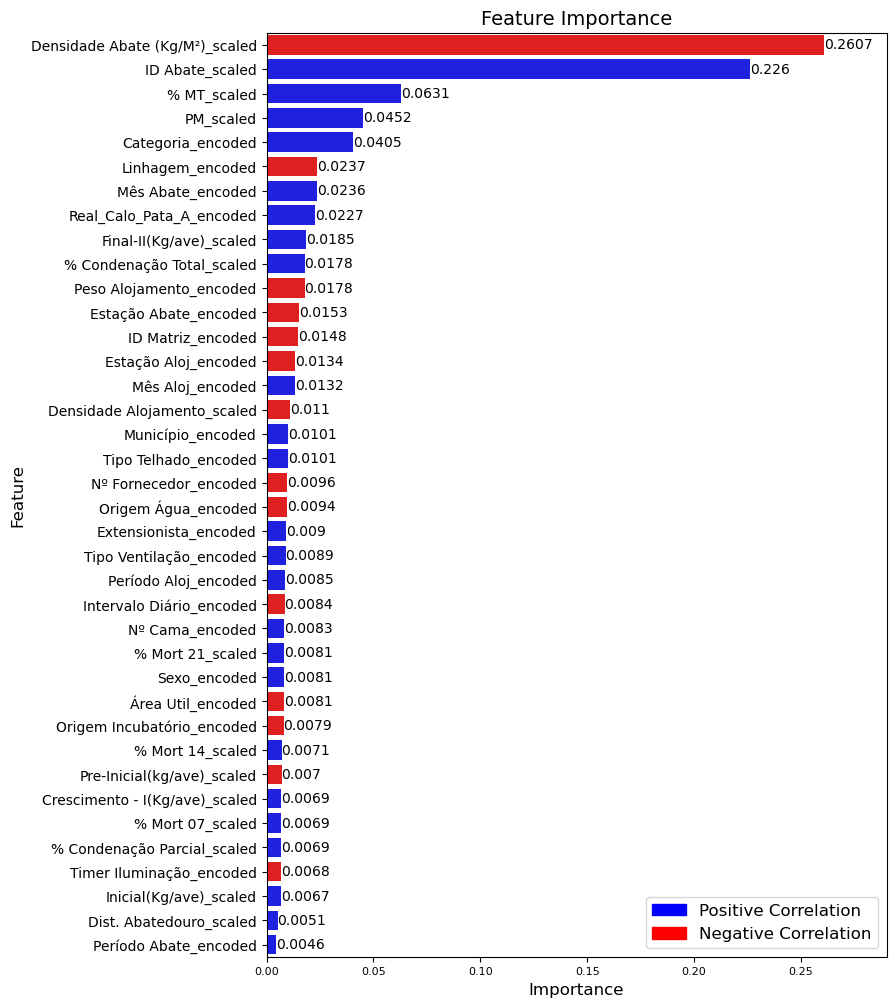

In [28]:
#Understading features importance
correlations = df[numerical_columns_scaled + categorical_columns_encoded].corrwith(df['CAAF'])

importances = best_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': numerical_columns_scaled + categorical_columns_encoded,
    'Importance': importances,
    'Correlation': correlations.values
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df['Color'] = ['blue' if corr > 0 else 'red' for corr in importance_df['Correlation']]

plt.figure(figsize=(8, 12))  
barplot = sns.barplot(x='Importance', y='Feature', data=importance_df, palette=importance_df['Color'])
plt.title('Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)

for index, value in enumerate(importance_df['Importance']):
    barplot.text(value, index, round(value, 4), color='black', ha="left", va="center", fontsize=10)

positive_patch = mpatches.Patch(color='blue', label='Positive Correlation')
negative_patch = mpatches.Patch(color='red', label='Negative Correlation')
plt.legend(handles=[positive_patch, negative_patch], loc='best', fontsize=12)

plt.xlim(0, 0.29)

plt.xticks(fontsize=8)  
plt.yticks(fontsize=10) 
plt.show()

C:\Users\502694\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\502694\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\502694\AppData\Local\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt t

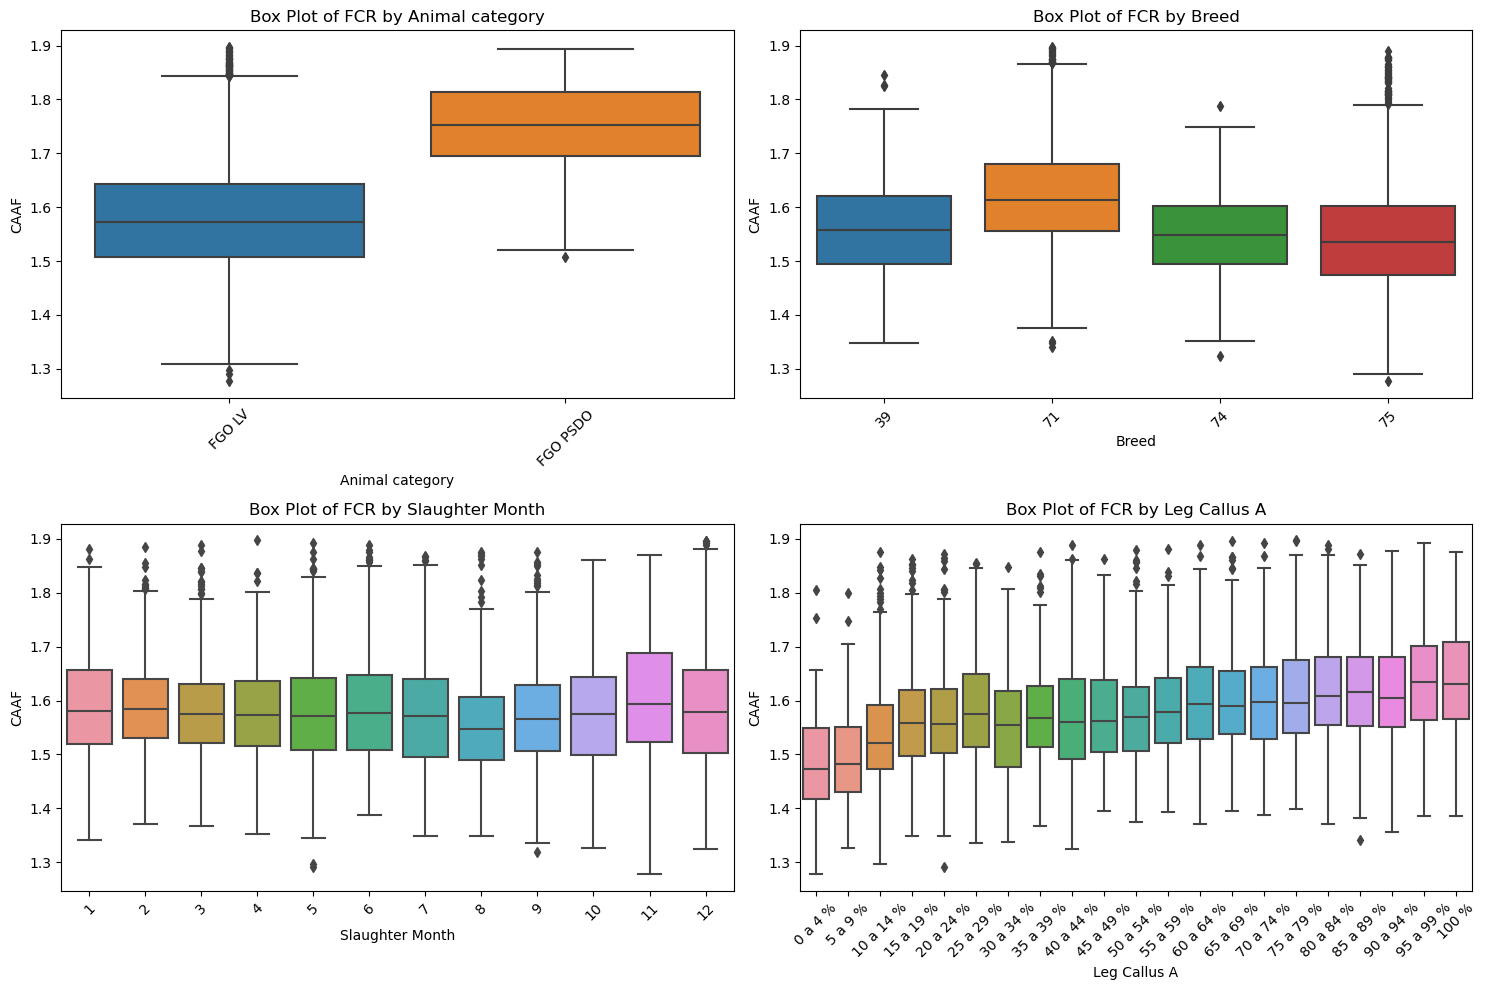

In [29]:
#Understading features importance
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(ax=axs[0, 0], x='Categoria', y='CAAF', data=df)
axs[0, 0].set_title('Box Plot of FCR by Animal category')
axs[0, 0].set_xlabel('Animal category')
axs[0, 0].set_ylabel('CAAF')
axs[0, 0].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axs[0, 1], x='Linhagem', y='CAAF', data=df)
axs[0, 1].set_title('Box Plot of FCR by Breed')
axs[0, 1].set_xlabel('Breed')
axs[0, 1].set_ylabel('CAAF')
axs[0, 1].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axs[1, 0], x='Mês Abate', y='CAAF', data=df)
axs[1, 0].set_title('Box Plot of FCR by Slaughter Month')
axs[1, 0].set_xlabel('Slaughter Month')
axs[1, 0].set_ylabel('CAAF')
axs[1, 0].tick_params(axis='x', rotation=45)

sns.boxplot(ax=axs[1, 1], x='Real_Calo_Pata_A', y='CAAF', data=df)
axs[1, 1].set_title('Box Plot of FCR by Leg Callus A')
axs[1, 1].set_xlabel('Leg Callus A')
axs[1, 1].set_ylabel('CAAF')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

C:\Users\502694\AppData\Local\Temp\ipykernel_15672\2041010778.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_caaf_by_farmer_linear = predictions_df_linear_farmer.groupby('Farmer')['Predicted CAAF'].mean().reset_index()
C:\Users\502694\AppData\Local\Temp\ipykernel_15672\2041010778.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_caaf_by_vet_linear = predictions_df_linear_vet.groupby('Veterinarian')['Predicted CAAF'].mean().reset_index()


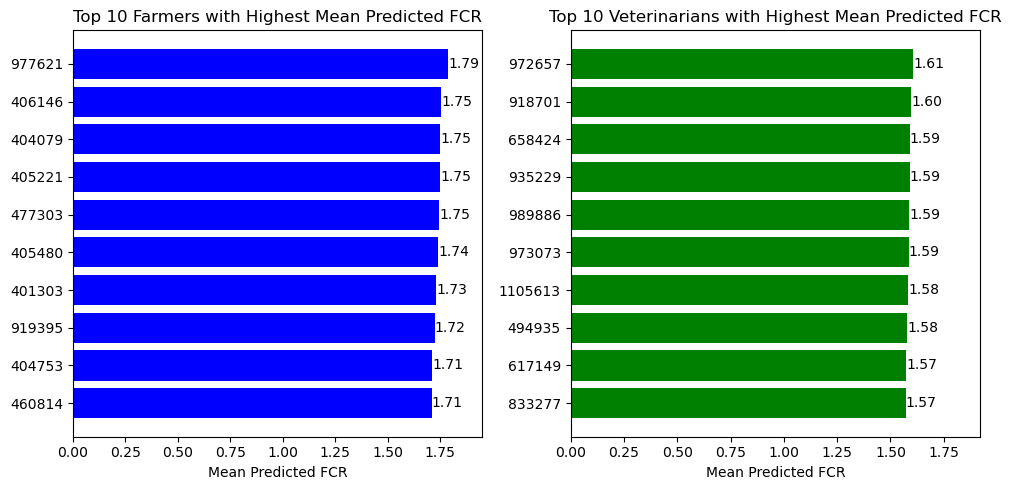

In [30]:
#TOP 10 farmers and veterinarians
# Converting X_test to a pandas DataFrame
X_test_df = pd.DataFrame(X_test, columns=numerical_columns_scaled + categorical_columns_encoded)

df_reset_index = df.reset_index(drop=True)

X_test_df['Farmer'] = df_reset_index.loc[X_test_df.index, 'Nº Fornecedor'].values
X_test_df['Veterinarian'] = df_reset_index.loc[X_test_df.index, 'Extensionista'].values

predictions_df_linear_farmer = pd.DataFrame({'Farmer': X_test_df['Farmer'],
                                      'Predicted CAAF': y_pred_tuned})
predictions_df_linear_vet = pd.DataFrame({'Veterinarian': X_test_df['Veterinarian'],
                                      'Predicted CAAF': y_pred_tuned})

mean_caaf_by_farmer_linear = predictions_df_linear_farmer.groupby('Farmer')['Predicted CAAF'].mean().reset_index()
mean_caaf_by_vet_linear = predictions_df_linear_vet.groupby('Veterinarian')['Predicted CAAF'].mean().reset_index()

mean_caaf_by_farmer_linear['Farmer'] = mean_caaf_by_farmer_linear['Farmer'].astype(str)
mean_caaf_by_vet_linear['Veterinarian'] = mean_caaf_by_vet_linear['Veterinarian'].astype(str)


top_10_farmers = mean_caaf_by_farmer_linear.nlargest(10, 'Predicted CAAF').sort_values(by='Predicted CAAF', ascending=True)
top_10_vets = mean_caaf_by_vet_linear.nlargest(10, 'Predicted CAAF').sort_values(by='Predicted CAAF', ascending=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

bars_fornecedor = axs[0].barh(top_10_farmers['Farmer'], top_10_farmers['Predicted CAAF'], color='blue')
axs[0].set_xlabel('Mean Predicted FCR')
axs[0].set_title('Top 10 Farmers with Highest Mean Predicted FCR')
axs[0].set_xlim(0, 1.95)

for bar in bars_fornecedor:
    axs[0].text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}', 
             va='center', ha='left')

bars_extensionista = axs[1].barh(top_10_vets['Veterinarian'], top_10_vets['Predicted CAAF'], color='green')
axs[1].set_xlabel('Mean Predicted FCR')
axs[1].set_title('Top 10 Veterinarians with Highest Mean Predicted FCR')
axs[1].set_xlim(0, 1.92)

for bar in bars_extensionista:
    axs[1].text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.2f}', 
             va='center', ha='left')

plt.tight_layout()
plt.show()

Group Summary:
         count   mean    std    min    25%    50%    75%    max
Group                                                          
Group 1   49.0  1.512  0.030  1.420  1.498  1.519  1.535  1.548
Group 2   49.0  1.565  0.009  1.549  1.559  1.564  1.572  1.579
Group 3   48.0  1.591  0.007  1.579  1.584  1.591  1.597  1.605
Group 4   49.0  1.654  0.050  1.606  1.615  1.634  1.685  1.787


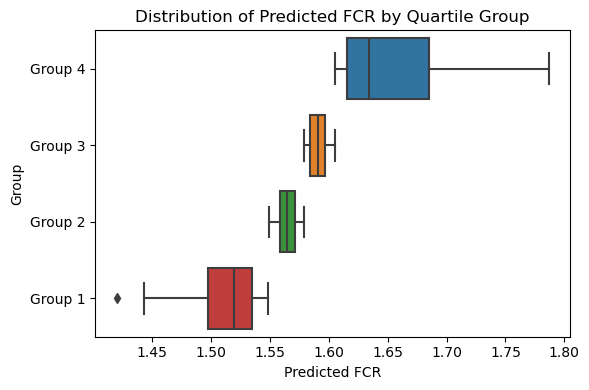

In [31]:
#Defining quartiles for predicted results
quartiles_farmer = mean_caaf_by_farmer_linear['Predicted CAAF'].quantile([0.25, 0.5, 0.75])

def group_farmers(caaf):
    if caaf <= quartiles_farmer[0.25]:
        return 'Group 1'
    elif caaf <= quartiles_farmer[0.5]:
        return 'Group 2'
    elif caaf <= quartiles_farmer[0.75]:
        return 'Group 3'
    else:
        return 'Group 4'

mean_caaf_by_farmer_linear['Group'] = mean_caaf_by_farmer_linear['Predicted CAAF'].apply(group_farmers)

mean_caaf_by_farmer_linear_sorted = mean_caaf_by_farmer_linear.sort_values(by='Predicted CAAF', ascending=False)

group_summary = mean_caaf_by_farmer_linear_sorted.groupby('Group')['Predicted CAAF'].describe().round(3)
print("Group Summary:")
print(group_summary)

plt.figure(figsize=(6, 4))
sns.boxplot(data=mean_caaf_by_farmer_linear_sorted, x='Predicted CAAF', y='Group', orient='h')
plt.xlabel('Predicted FCR')
plt.title('Distribution of Predicted FCR by Quartile Group')
plt.tight_layout()
plt.show()

count    195.000
mean       1.580
std        0.059
min        1.420
25%        1.549
50%        1.579
75%        1.605
max        1.787
Name: Predicted CAAF, dtype: float64


C:\Users\502694\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


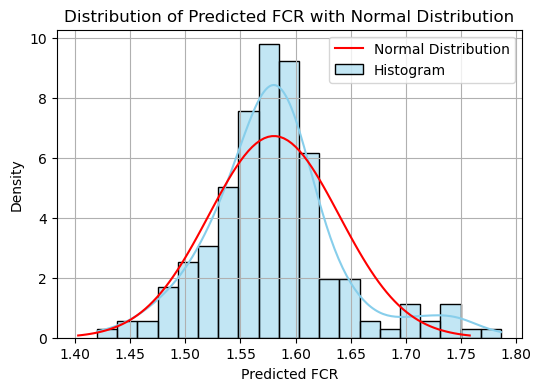

In [32]:
#Normal curve predicted values
print(mean_caaf_by_farmer_linear_sorted['Predicted CAAF'].describe().round(3))

predicted_caaf = mean_caaf_by_farmer_linear['Predicted CAAF']

mean_predicted_caaf = predicted_caaf.mean()
std_predicted_caaf = predicted_caaf.std()

x = np.linspace(mean_predicted_caaf - 3*std_predicted_caaf, mean_predicted_caaf + 3*std_predicted_caaf, 100)

pdf = (1/(std_predicted_caaf * np.sqrt(2 * np.pi))) * np.exp(-(x - mean_predicted_caaf)**2 / (2 * std_predicted_caaf**2))

plt.figure(figsize=(6, 4))
sns.histplot(predicted_caaf, kde=True, stat='density', color='skyblue', bins=20, label='Histogram')

plt.plot(x, pdf, color='red', label='Normal Distribution')

plt.xlabel('Predicted FCR')
plt.ylabel('Density')
plt.title('Distribution of Predicted FCR with Normal Distribution')
plt.legend()
plt.grid(True)
plt.show()